### extract diffraction peak positions and diffraction peak intensity of a 4D-STEM dataset with spot patterns
* load dataset
* adjust parameters interactively
* save results to pickle file

Package versions:<br>
python==3.10.8<br>
numpy==1.23.5<br>
matplotlib==3.6.2<br>
ipywidgets==8.0.4<br>
scipy==1.10.0<br>
pickleshare==0.7.5<br>
joblib==1.2.0<br>
tqdm==4.64.1<br>
h5py==3.7.0

In [1]:
%matplotlib widget

In [2]:
# load packages
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import ipywidgets as widgets
from scipy import ndimage
from scipy import fft as fft
import pickle
from datetime import datetime
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import h5py

In [3]:
# define parameters
data_folder = r"..\data\Figure 2_3_S1\230101205338_20kV_hexz0_camz-10_posi_003_good"
data_name = r"\scan_data_bin2_centered_crop-imgNx200.h5"
data_path = data_folder + data_name
data_format = data_name.split(".")[-1]
data_type = 'u1'
img_Nx = 400; img_Ny = img_Nx
scan_Nx = 192; scan_Ny = scan_Nx
scan_N = scan_Nx * scan_Ny
binning_factor = 2
calibration_factor_no_binning = 0.064590 #1/nm
calibration_factor = calibration_factor_no_binning * binning_factor

# load num_img images to optimze parameters
num_img = 50
load_random_img = 1 # = 1: load num_img random images from dataset; = 0: load num_img linear spaced

# parameters to get diffraction peak position
gaussf0_val = 1.0
gaussf1_val = 10.0
substract_val = 2.0

In [4]:
data_path

'..\\data\\Figure 2_3_S1\\230101205338_20kV_hexz0_camz-10_posi_003_good\\scan_data_bin2_centered_crop-imgNx200.h5'

In [5]:
%%time
if data_format == 'raw':
    ds = np.memmap(data_path, dtype=np.dtype(data_type), mode='r', shape=(scan_Ny,scan_Nx,img_Ny, img_Nx))
    ds_shape = ds.shape

if data_format == 'h5':
    #with h5py.File(data_path, 'r') as f: # Load the file
    #    ds = f['data'] # Get the data
    #    ds_shape = ds.shape
    f =  h5py.File(data_path, 'r') # Load the file
    ds = f['data'] # Get the data
    ds_shape = ds.shape

if load_random_img:
    data_select = np.array([np.random.randint(low = 0, high = scan_Ny, size = num_img), np.random.randint(low = 0, high = scan_Nx, size = num_img)])
if load_random_img == 0:
    xy = np.round(np.linspace(0,scan_N-1,num_img))    
    y = (np.floor(xy/scan_Ny)).astype(int)
    x = (xy%scan_Nx).astype(int)
    data_select = np.array([y,x])

data = np.zeros((num_img, ds_shape[2], ds_shape[3]))
for it in range(num_img): # no fanzy indexing in h5py
    data[it,:,:] = ds[data_select[0][it],data_select[1][it],:,:]


(scan_Ny, scan_Nx, img_Ny, img_Nx) = ds.shape
(scan_Ny, scan_Nx, img_Ny, img_Nx)

CPU times: total: 594 ms
Wall time: 589 ms


(192, 192, 200, 200)

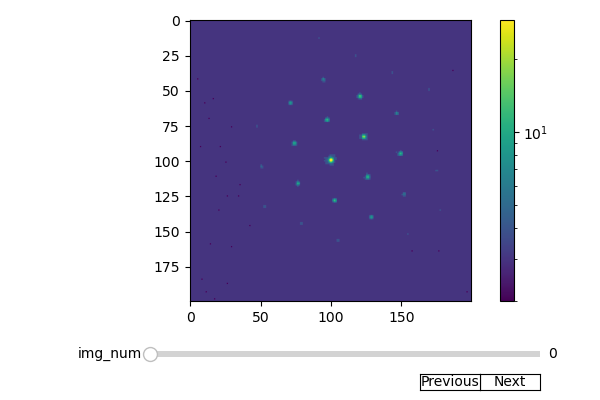

In [6]:
if 1:
    # plot diffraction patterns interactively
    fig = plt.figure(figsize = (6,4))
    ax1 = fig.add_subplot(1,1,1)
    im1 = ax1.imshow(data[0,:,:]+1, norm=matplotlib.colors.LogNorm()) #, cmap = 'gray'
    fig.colorbar(im1)
    fig.subplots_adjust(left=0.25,bottom=0.25)
    plt.tight_layout(rect = (0,0.15,1,1))
    img_num = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    smin = Slider(img_num, 'img_num', 0, num_img-1, valinit=0, valstep=1)
    button_n_ax = plt.axes([0.8, 0.025, 0.1, 0.04])
    button_n = Button(button_n_ax, 'Next', color='w', hovercolor='skyblue')
    button_p_ax = plt.axes([0.7, 0.025, 0.1, 0.04])
    button_p = Button(button_p_ax, 'Previous', color='w', hovercolor='skyblue')
    def update(val):
        img = data[int(val),:,:]+1
        im1.set_data(img)
        im1.set_clim(img.min(), img.max())
        fig.canvas.draw()
    def update_button_next(self):
        smin.val = int((smin.val + 1))%num_img
        update(smin.val)
        smin.set_val(smin.val)
    def update_button_prev(self):
        smin.val = int((smin.val - 1))%num_img
        update(smin.val)
        smin.set_val(smin.val)
    smin.on_changed(update)
    button_n.on_clicked(update_button_next)
    button_p.on_clicked(update_button_prev)
    plt.show()

In [7]:
def process_single_img0(img, gaussf0_val, gaussf1_val, substract_val):
    img = img - substract_val
    img[img < 0.0] = 0
    img_gauss0 = ndimage.gaussian_filter(img, gaussf0_val)
    img_gauss1 = ndimage.gaussian_filter(img, gaussf1_val)
    img_diff = img_gauss0 - img_gauss1
    img_diff[img_diff < 0.0] = 0
    img_diff_bool = img_diff.astype(bool)
    img_diff_bool[img - img_gauss1 < 0] = False
    return img_diff_bool

def process_single_img1(img_orig,img_bool, max_num_labels = 50):
    label, num_label = ndimage.label(img_bool == True) # 318 µs
    if num_label > max_num_labels:
        num_label = max_num_labels
    pos1 = np.zeros((num_label, 2))
    pos_int0 = np.zeros((num_label))
    for it0 in range(num_label): 
        pos0 = np.where(label == it0 + 1)
        pos1[it0, 0] = np.mean(pos0[0])
        pos1[it0, 1] = np.mean(pos0[1])
        pos_int0[it0] = np.sum(img_orig[pos0[0],pos0[1]])
    return pos1, pos_int0 

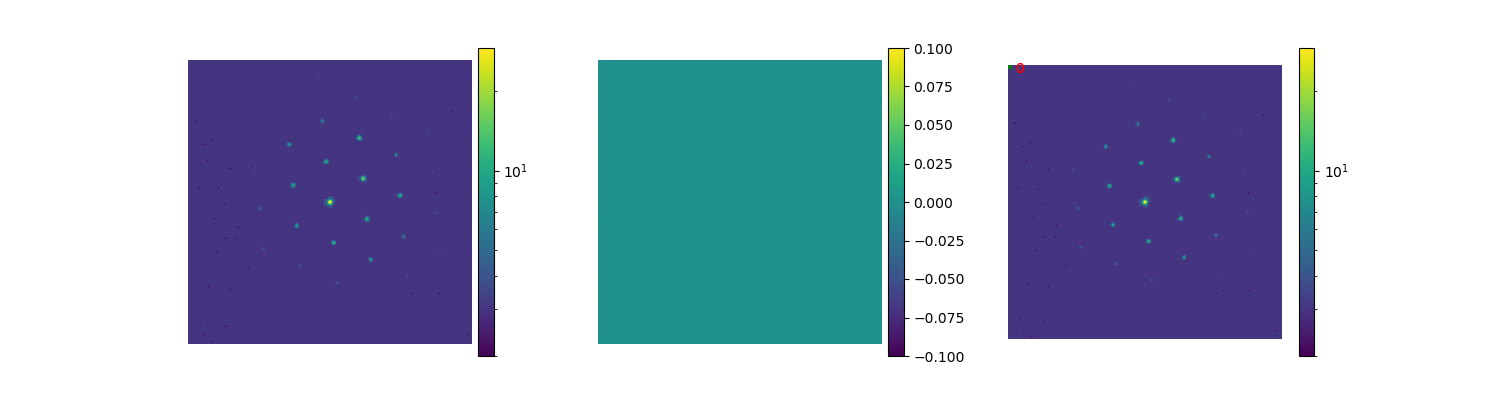

In [8]:
# interactively plot filtered diffraction pattern, adjust parameters and process data
# click "process data" to see if thresholding worked (needed for getting peak positions and intensities)
# click "process data1" to get peak positions and intensities
widget_output = widgets.Output()

with widget_output:
    fig, ax = plt.subplots(1,3, figsize=(15, 4), constrained_layout=False)


# remember old img_pos value
try:
    img_pos
except NameError:
    img_pos = 0


data_copy = np.copy(data) 
data_proc0 = np.zeros_like(data_copy) 
data_proc0_shape = data_proc0.shape
pos1 = [np.zeros((2,2))]*data_proc0_shape[0]
pos_int0 = [np.zeros((2))]*data_proc0_shape[0]
    
# create control elements
int_slider = widgets.IntSlider(value=0, min=0, max=num_img-1, step=1, description='image')
float_text_gaussf0_val = widgets.FloatText(value=gaussf0_val, description='gaussf0_val', disabled=False)
float_text_gaussf1_val = widgets.FloatText(value=gaussf1_val, description='gaussf1_val', disabled=False)
float_text_substract_val = widgets.FloatText(value=substract_val, description='substract_val', disabled=False)
button_process = widgets.Button(description='process data', disabled=False, button_style='')
button_process1 = widgets.Button(description='process1 data', disabled=False, button_style='')


fig.canvas.draw()

def update_im(change):
    #print('update_im')
    global annos
    img_pos = int_slider.value
    im1.set_data(data[img_pos,:,:]+1)
    im1.set_clim([(data[img_pos,:,:]+1).min(), (data[img_pos,:,:]+1).max()])
    im2.set_data(data_proc0[img_pos,:,:])
    im2.set_clim([(data_proc0[img_pos,:,:]).min(), (data_proc0[img_pos,:,:]).max()])
    im3.set_data(data[img_pos,:,:]+1)
    im3.set_clim([(data[img_pos,:,:]+1).min(), (data[img_pos,:,:]+1).max()])
    im3_.set_ydata(pos1[img_pos][:,0])
    im3_.set_xdata(pos1[img_pos][:,1])
    for it in range(len(annos)):
        annos[it].remove()
    annos = list(range(pos1[img_pos].shape[0]))
    for it0 in range(pos1[img_pos].shape[0]):
        annos[it0] = ax[2].annotate(str(pos_int0[img_pos][it0].astype(int)), xy = (pos1[img_pos][it0,1]+5,pos1[img_pos][it0,0]+5), color = "r")
    
def update_gaussf0_val(change):
    global gaussf0_val 
    gaussf0_val = float_text_gaussf0_val.value

def update_gaussf1_val(change):
    global gaussf1_val 
    gaussf1_val = float_text_gaussf1_val.value
    
def update_substract_val(change):
    global substract_val 
    substract_val = float_text_substract_val.value


def process(val0):
    global data_copy
    global data_proc0
    global gaussf0_val
    global gaussf1_val
    global substract_val
    global pos1
    global pos_int0
    update_gaussf0_val(val0)
    update_gaussf1_val(val0)
    update_substract_val(val0)
    data_copy = np.copy(data)
    
    for it in range(data_copy.shape[0]):
        data_proc0[it,...] = process_single_img0(data_copy[it,...], gaussf0_val, gaussf1_val, substract_val)
        
    update_im(val0)
    
def process1(val0):
    global data_copy
    global data_proc0
    global gaussf0_val
    global gaussf1_val
    global substract_val
    global pos1
    global pos_int0
    update_gaussf0_val(val0)
    update_gaussf1_val(val0)
    update_substract_val(val0)
    pos1 = [np.zeros((2,2))]*data_proc0_shape[0]
    pos_int0 = [np.zeros((2))]*data_proc0_shape[0]
    
    for it in range(data_copy.shape[0]):
        pos1[it], pos_int0[it]  = process_single_img1(data_copy[it,...], data_proc0[it,...])
        
    update_im(val0)

# create plots
colorbar_pad = 0.02
im1 = ax[0].imshow(data_copy[img_pos,:,:]+1, norm=matplotlib.colors.LogNorm()) # data_proc0
ax[0].axis('off')
fig.colorbar(im1, ax = ax[0], pad = colorbar_pad)
im2 = ax[1].imshow(data_proc0[img_pos,:,:]) #,cmap = 'gray'
ax[1].axis('off')
fig.colorbar(im2, ax = ax[1], pad = colorbar_pad)    
im3 = ax[2].imshow(data_copy[img_pos,:,:]+1, norm=matplotlib.colors.LogNorm())
ax[2].axis('off')
fig.colorbar(im3, ax = ax[2])
im3_, = ax[2].plot(pos1[img_pos][:,1],pos1[img_pos][:,0], 'gx', markerfacecolor='none', markersize=5)
annos = list(range(pos1[img_pos].shape[0]))
for it0 in range(pos1[img_pos].shape[0]):
    annos[it0] = ax[2].annotate(str(pos_int0[img_pos][it0].astype(int)), xy = (pos1[img_pos][it0,1]+5,pos1[img_pos][it0,0]+5), color = "r") 

# connect callbacks and traits
int_slider.observe(update_im, 'value')
float_text_gaussf0_val.observe(update_gaussf0_val, 'value')
float_text_gaussf1_val.observe(update_gaussf1_val, 'value')
float_text_substract_val.observe(update_substract_val, 'value')
button_process.on_click(process)
button_process1.on_click(process1)

controls0 = widgets.HBox([int_slider, float_text_gaussf0_val, float_text_gaussf1_val, float_text_substract_val])
controls1 = widgets.HBox([button_process, button_process1])
controls = widgets.VBox([controls0, controls1])
widgets.HBox([controls, widget_output])

In [9]:
(xm, ym) = np.meshgrid(range(scan_Nx), range(scan_Ny))
xm_flat = xm.flatten()
ym_flat = ym.flatten()

max_num_labels = 50

def process_data_parallel(img, gaussf0_val, gaussf1_val, substract_val, max_num_labels):
    #data_proc0 = process_single_img0(img, gaussf0_val, gaussf1_val, substract_val)
    #pos1, pos_int0  = process_single_img1(img, data_proc0)
    img = img - substract_val
    img[img < 0.0] = 0
    img_gauss0 = ndimage.gaussian_filter(img, gaussf0_val)
    img_gauss1 = ndimage.gaussian_filter(img, gaussf1_val)
    img_diff = img_gauss0 - img_gauss1
    img_diff[img_diff < 0.0] = 0
    img_diff_bool = img_diff.astype(bool)
    img_diff_bool[img - img_gauss1 < 0] = False

    label, num_label = ndimage.label(img_diff_bool == True)
    if num_label > max_num_labels:
        num_label = max_num_labels
    pos1 = np.zeros((num_label, 2))
    pos_int0 = np.zeros((num_label))
    for it0 in range(num_label): 
        pos0 = np.where(label == it0 + 1)
        pos1[it0, 0] = np.mean(pos0[0])
        pos1[it0, 1] = np.mean(pos0[1])
        pos_int0[it0] = np.sum(img[pos0[0],pos0[1]])
    
    return pos1, pos_int0

In [10]:
%%time 
# process complete dataset
# load complete dataset into RAM # if RAM is not large enough, load partially: dataset = ds[0:50,:,:,:]
dataset = ds[()]
process_num_img = scan_N

pos, pos_int = zip(*Parallel(n_jobs=-1, verbose = 0)(delayed(process_data_parallel)(dataset[ym_flat[it], xm_flat[it],:,:], gaussf0_val, gaussf1_val, substract_val, max_num_labels) for it in tqdm(range(process_num_img))))

#convert tuples to lists
pos = list(pos)
pos_int = list(pos_int)

  0%|          | 0/36864 [00:00<?, ?it/s]

CPU times: total: 9.19 s
Wall time: 14 s


In [11]:
#example: create image with number of found diffraction peaks per scan position
num_points = np.zeros((scan_Ny,scan_Nx))
it = 0
for ity in range(scan_Ny):
    for itx in range(scan_Nx):
        num_points[ity, itx] = pos[it].shape[0]
        it = it + 1
plt.figure(figsize = (6,5))
plt.imshow(np.log(num_points)) # , vmax = 5
plt.colorbar()

C:\Users\JMe\AppData\Local\Temp\ipykernel_32884\3882541853.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(num_points)) # , vmax = 5


In [12]:
%%time
#write results and parameter to disk
parameter_file_name = datetime.now().strftime("%Y%m%d_%H%M%S")
data = dict([(i, globals()[i]) for i in ('data_folder','data_name','data_path',
                                         'img_Nx','img_Ny','scan_Nx','scan_Ny','scan_N','num_img',
                                         'binning_factor', 'calibration_factor_no_binning', 'calibration_factor',
                                         'gaussf0_val','gaussf1_val','substract_val',
                                         'num_points',
                                         'pos', 'pos_int'
                                         )])
with open(data_folder + r'//' + parameter_file_name + data_name.split('.')[0][1:] + 'diff_peak_posV2.pkl', 'wb') as f:
    pickle.dump(data, f)

CPU times: total: 344 ms
Wall time: 348 ms
